# Vineland stratification pipeline

In this 1st script, which is a pipeline, we build the vineland stratification model by using the *reval* library.
<br> The script recals multiple functions from the folder *strat*, which contains the major functions for running this projects: from datawrangling to running *reval*

In [1]:
#import libraries
from strat.create_dataset import dataset, prepare_imputation
from strat.run_rcv_vero import RCV, relabel # modify here by vero
#from strat.run_rcv_vero_noumap import RCV, relabel # modify here by vero
import sklearn
import strat.utils as ut # in the utils file you can specify the directories
import logging
import numpy as np
import pandas as pd
from strat.create_long_ndar import build_long
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
import re
from sklearn.preprocessing import StandardScaler
from umap import UMAP
from strat.ucsd_dataset import prepare_ucsd, predict_labels, create_new
import pickle as pkl
import os
from reval.best_nclust_cv import FindBestClustCV
from sklearn.cluster import KMeans
from strat.visualization import _scatter_plot
from strat.run_rcv_vero import _build_distmat
import tqdm

logging.basicConfig(format='%(asctime)s %(levelname)s: %(message)s',
                    level=logging.INFO, datefmt='%I:%M:%S')

## Import Vineland datasets from NDAR and clean data

In [5]:
# merge all the vineland dataset using the function dataset dwoloaded from NDA

vineland, demo_info = dataset(ut.instrument_dict, # dictionary for the instrument (Vinaland files) to use specified in the utils.py file
                              ut.phenotype_file, # dictionary for the phenotypes specified in the utils.py file
                              phenotype='autism', # phenotype included in the analis 
                              ptype=2, # ptype = how to create the age bins, "2" creates 2 bins (split at 72 months), "1" creates 5 bins
                              save=True)  # saving options# ptype = How Isotta created the age bins --> there are 2 ways p2 keeps only underd 72 and over 72 months

# the output

09:42:44, INFO Select individuals with autism and save demographic info.
09:43:06, INFO Number of subjects with autism: 17772


09:43:06, INFO Loading datasets:
09:43:06, INFO vinelandsurvey_200505
09:43:07, INFO Read table vinelandsurvey_200505 -- N subjects (unique): 2872 (1513)

09:43:07, INFO vinelandparent_200503
09:43:08, INFO Read table vinelandparent_200503 -- N subjects (unique): 1904 (1290)

09:43:08, INFO vinland301
09:43:08, INFO Read table vinland301 -- N subjects (unique): 1818 (445)

09:43:08, INFO Processing VINELAND
09:43:09, INFO Dropped 104 observations with completely missing information
09:43:09, INFO Dropped 1544 duplicated observations
09:43:09, INFO Dropped 357 subjects from UCSD longitudinal study
09:43:09, INFO Current number of observation: 4589




In [6]:
#take a look at the VINELAND 
vineland.head(10) 

,interview_period,collection_id,interview_age,interview_date,edition,relationship,receptivesubdomain_1,expressivesubdomain_2,writtensubdomain_3,communicationdomain_totalb,...,domesticsubdomain_2,communitysubdomain_3,livingskillsdomain_totalb,interpersrelationsubdom_1,playleisuretimesubdomain_2,copingskillssubdomain_3,socializationdomain_totalb,motorskillsdomain_totalb,composite_totalb,sex
subjectkey,,,,,,,,,,,,,,,,,,,,,
NDARAA370VTG,P2,1952.0,74.0,2012-09-03,2.0,NaN,18.0,36.0,7.0,57.0,...,7.0,10.0,55.0,32.0,17.0,8.0,63.0,61.0,NaN,M
NDARAA370VTG,P2,1952.0,83.0,2013-05-09,2.0,NaN,19.0,40.0,8.0,57.0,...,7.0,10.0,55.0,26.0,13.0,13.0,61.0,67.0,NaN,M
NDARAA668AC0,P1,1.0,50.0,2008-11-13,2.0,1,23.0,36.0,5.0,72.0,...,2.0,2.0,55.0,31.0,8.0,12.0,66.0,72.0,63.0,M
NDARAA787KKZ,P2,2020.0,78.0,2015-07-31,2.0,NaN,16.0,12.0,3.0,42.0,...,2.0,2.0,43.0,19.0,11.0,3.0,51.0,56.0,46.0,M
NDARAA864ZGK,P1,1600.0,64.0,2011-10-05,2.0,NaN,18.0,NaN,9.0,NaN,...,4.0,2.0,51.0,NaN,5.0,NaN,NaN,NaN,NaN,M
NDARAA898JB2,P2,2288.0,104.0,2018-02-05,3.0,NaN,60.0,92.0,51.0,78.0,...,15.0,51.0,82.0,59.0,37.0,41.0,73.0,NaN,76.0,F
NDARAA898JB2,P2,2288.0,108.0,2018-07-24,3.0,NaN,63.0,93.0,56.0,79.0,...,25.0,60.0,85.0,64.0,44.0,49.0,77.0,NaN,78.0,F
NDARAB376BVY,P2,2030.0,122.0,2015-05-07,2.0,1,35.0,102.0,37.0,84.0,...,25.0,53.0,91.0,49.0,36.0,11.0,64.0,NaN,77.0,M
NDARAB580EUC,P2,2025.0,214.0,2016-07-11,2.0,NaN,27.0,47.0,4.0,40.0,...,24.0,11.0,45.0,19.0,26.0,9.0,45.0,NaN,42.0,F


## Stability-based relative clustering validation 

> Initialize class;

> Run the model either within grid-search or with best parameters.

In [7]:
# Initialize stability-based relative clustering validation class

rcv_method = RCV(ptype=2, #  ptype = how to create the age bins, "2" creates 2 bins (split at 72 months), "1" creates 5 bins
                 include_age=['P1'], # age bin to include in the analysis: P1 <72 months, P2 >72months
                 trts_perc=0.45)   # percentage of train/test split (% to be included in the test)

#define useful features (= domain + demo_features) to run the clustering
domain_feat = [c for c in vineland.columns if re.search('totalb', c) and not re.search('composite', c)]
useful_feat =  ['sex','interview_age','interview_period','collection_id']+ domain_feat

#rcv_method.prepare_cs_dataset(prepare_imputation(vineland[useful_feat]))

In [7]:
# this is the grid search, runed once is runned forever!

#best_param, _ = rcv_method.gridsearch_cv(vineland[useful_feat], n_neigh=[5, 10, 15], 
#                                         na_perc=[0.10, 0.35, 0.50], cl_range=list(range(2, 11, 1)), 
#                                         cv_fold=[3],
#                                         iter_cv=100,
#                                         save='gridsearch_perf_ptype2_p1_dom_only')

  0%|          | 0/3 [00:00<?, ?it/s]

Training Fold Number 3


100%|██████████| 3/3 [4:22:38<00:00, 5252.72s/it]  
17:07:05, INFO Best parameters selected: {'cv': 3, 'na_perc': 0.35, 'n_neigh': 5} -- Scores {'avg_val_ms': 0.04415806797803712, 'avg_test_ms': 0.02020202020202022, 'avg_conf_width': 0.006967068772801177}


In [9]:
# Best parameters selected by grid-search (insert them here)

best_param ={'cv': 3, 'na_perc': 0.35, 'n_neigh': 5} 
best_param

{'cv': 3, 'na_perc': 0.35, 'n_neigh': 5}

09:43:19, INFO Percentage of missing information for each feature:
{'communicationdomain_totalb': 0.009588145565482676, 'livingskillsdomain_totalb': 0.009152320767051645, 'socializationdomain_totalb': 0.011985181956853346, 'motorskillsdomain_totalb': 0.5269121813031161}
Median - Min/Max percentage of missing information per subject:0.25 - 0.0/1.0
09:43:19, INFO Threshold set at: 0.35
09:43:19, INFO Dropped 59
09:43:19, INFO Number of subjects at P1: 1098
09:43:19, INFO Number of subjects in training set: 603
09:43:19, INFO Number of subjects in test set: 495


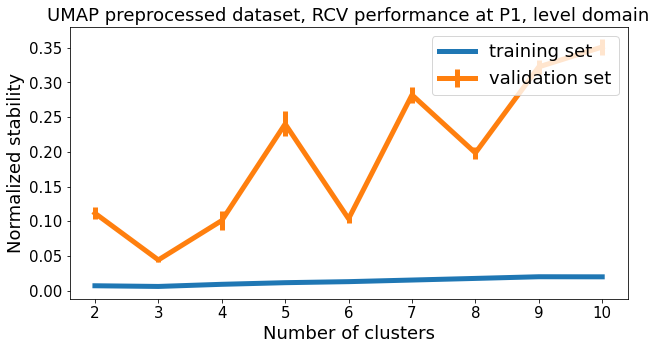

10:19:16, INFO Best number of clusters: 3
10:19:16, INFO Training ACC: 0.9917081260364843, Test ACC: 0.9797979797979798


Loading BokehJS ...

Loading BokehJS ...

10:19:17, INFO Saving train/test datasets with new cluster
10:19:17, INFO Building distance matrix...


In [10]:
# Run relative clustering validation with best parameters
dict_imp,strat_sex,strat_agesexed,X_tr,metric = rcv_method.run_rcv(vineland[useful_feat],
                              demo_info, 
                              na_perc=best_param['na_perc'], 
                              n_neigh=best_param['n_neigh'], 
                              cv_fold=best_param['cv'], 
                              cl_range=list(range(2, 11, 1)), # clustester range to try
                              iter_cv=100,  # number of cross validation repetition
                              scatter=True, 
                              heatmap=True)

# Save the results

In [14]:
for table in metric.keys():
    data = pd.DataFrame(columns=['k','value','CI'])
    for row in metric[table]:
        _dict_append = {'k':row,
                     'value':metric[table][row][1][0],
                     'CI':metric[table][row][1][1]}
        data= data.append(_dict_append,ignore_index=True)
        
    data.to_csv('_'.join([table,'metric_P14soggettti.csv']))


In [ ]:
## STOP HERE